# Bayesian Gaussian Mixture Model in Pyro

Trying to figure it out for myself without using autoguide.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc("text", usetex=True)
rc("font", family = "serif")
rc("figure",figsize=(9,6))
rc("figure",facecolor="white")
%config InlineBackend.figure_format = 'retina'
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import torch
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
from torch.nn import Parameter
from torch.distributions import constraints
import sklearn

In [262]:
N_classes = 5
dims = 3
true_means = 10*torch.randn((N_classes,dims))

covs = torch.ones(N_classes,dims,dims) + 2*torch.randn(N_classes,dims,dims)
covs = torch.bmm(covs,covs.permute(0,2,1))

generating_dists = dist.MultivariateNormal(true_means,covs)

data = generating_dists.sample(torch.Size([100])).permute(1,0,2)

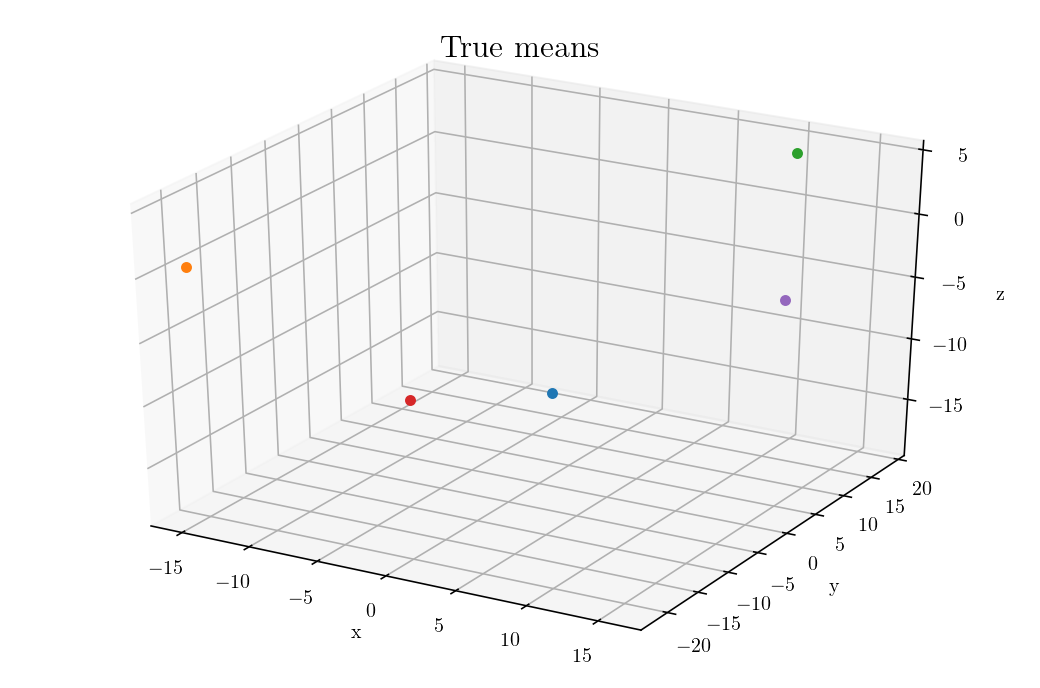

In [263]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(N_classes):
    ax.scatter(true_means[i,0], true_means[i,1], true_means[i,2])
ax.set_xlabel(r"x")
ax.set_ylabel(r"y")
ax.set_zlabel(r"z")
plt.title(r"True means",fontsize=16)
plt.show()

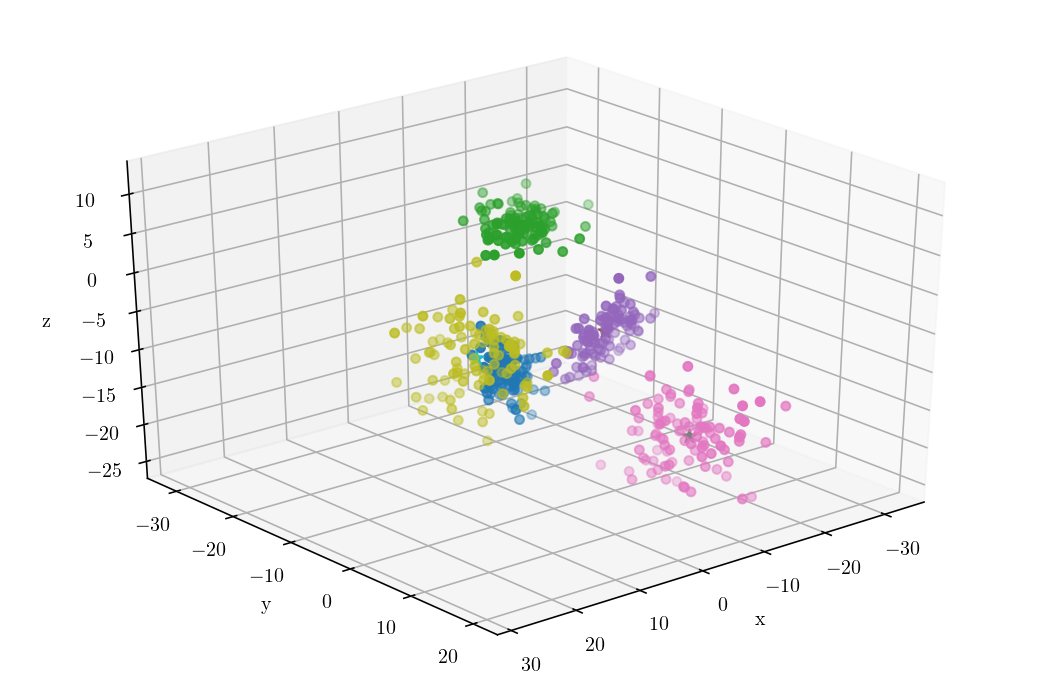

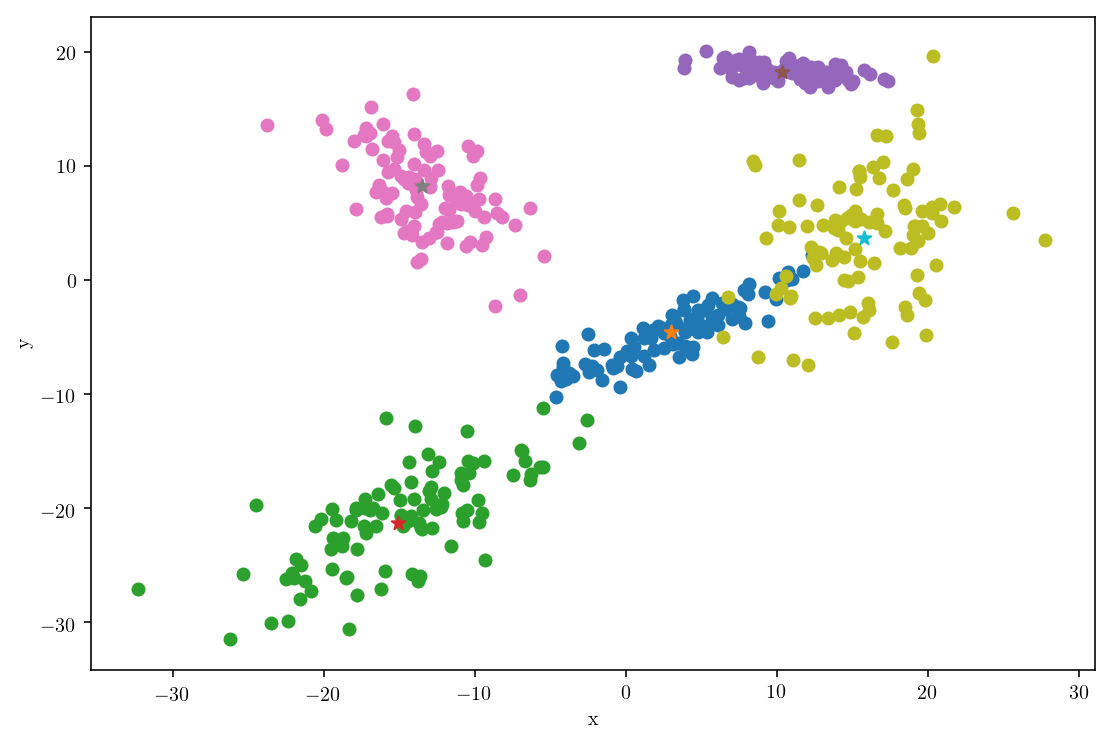

In [264]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(N_classes):
    ax.scatter(data[i,:,0], data[i,:,1], data[i,:, 2])
    ax.scatter(true_means[i,0],true_means[i,1],true_means[i,2],marker="*",s=50)
ax.set_xlabel(r"x")
ax.set_ylabel(r"y")
ax.set_zlabel(r"z")
ax.view_init(30, 50)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
for i in range(N_classes):
    ax.scatter(data[i,:,0], data[i,:,1])
    ax.scatter(true_means[i,0], true_means[i,1],marker="*",s=50)
ax.set_xlabel(r"x")
ax.set_ylabel(r"y")
#ax.set_zlabel(r"z")
#plt.title(r"True means",fontsize=16)
plt.show()

### Now lets use pyro to infer the parameters of the mixtures

In [231]:
from pyro.infer import SVI, TraceEnum_ELBO, Trace_ELBO, config_enumerate, infer_discrete
from pyro.optim import Adam
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro import poutine
import warnings
from pyro import poutine

In [16]:
warnings.filterwarnings("ignore")

In [17]:
train_data = data.reshape((N_classes*100,dims))
N_data = train_data.shape[0]

In [63]:
pyro.enable_validation(True)

In [265]:
def model(data):
    #global variables
    weights = torch.randint(1,4,(N_classes,)).to(torch.float).softmax(0)
    with pyro.plate("classes"):
        normal = dist.MultivariateNormal(torch.zeros((N_classes,dims)),torch.diag_embed(10*torch.ones((N_classes,dims))))
        means = pyro.sample('means', normal)
        scales = pyro.sample('scales',dist.Gamma(10*torch.ones((N_classes,dims)),2*torch.ones((N_classes,dims))).to_event(1))
    with pyro.plate('data',data.shape[0]) as idx:
        c = pyro.sample('c',dist.Categorical(weights)).to(torch.long)
        pyro.sample('x',dist.MultivariateNormal(means[c],torch.diag_embed(scales[c])), obs=data[idx])
        

In [266]:
def guide(data):
    #variational params
    phi = pyro.param('phi',torch.stack(data.shape[0]*(torch.ones(N_classes)/N_classes,)),constraint=constraints.simplex)
    m_loc = pyro.param('m_loc',10*torch.randn((N_classes,dims)))
    m_scale = pyro.param('m_scale',5*torch.stack(N_classes*(torch.eye(dims),)) ,constraint=constraints.lower_cholesky)
    s_shape = pyro.param('s_shape',10*torch.rand(N_classes,dims), constraint=constraints.positive)
    s_rate = pyro.param('s_rate', 0.5*torch.ones((N_classes,dims)) ,constraint=constraints.positive)
    
    #model latent vars
    with pyro.plate('classes'):
        means = pyro.sample('means',dist.MultivariateNormal(m_loc,scale_tril=m_scale))
        scales = pyro.sample('scales',dist.Gamma(s_shape, s_rate).to_event(1))

    with pyro.plate('data',data.shape[0]):
        c = pyro.sample('c',dist.Categorical(phi)).to(torch.long)

In [267]:
adam_params = {"lr": 0.05, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)
# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=TraceEnum_ELBO(max_plate_nesting=1), num_samples=100)

<function matplotlib.pyplot.show>

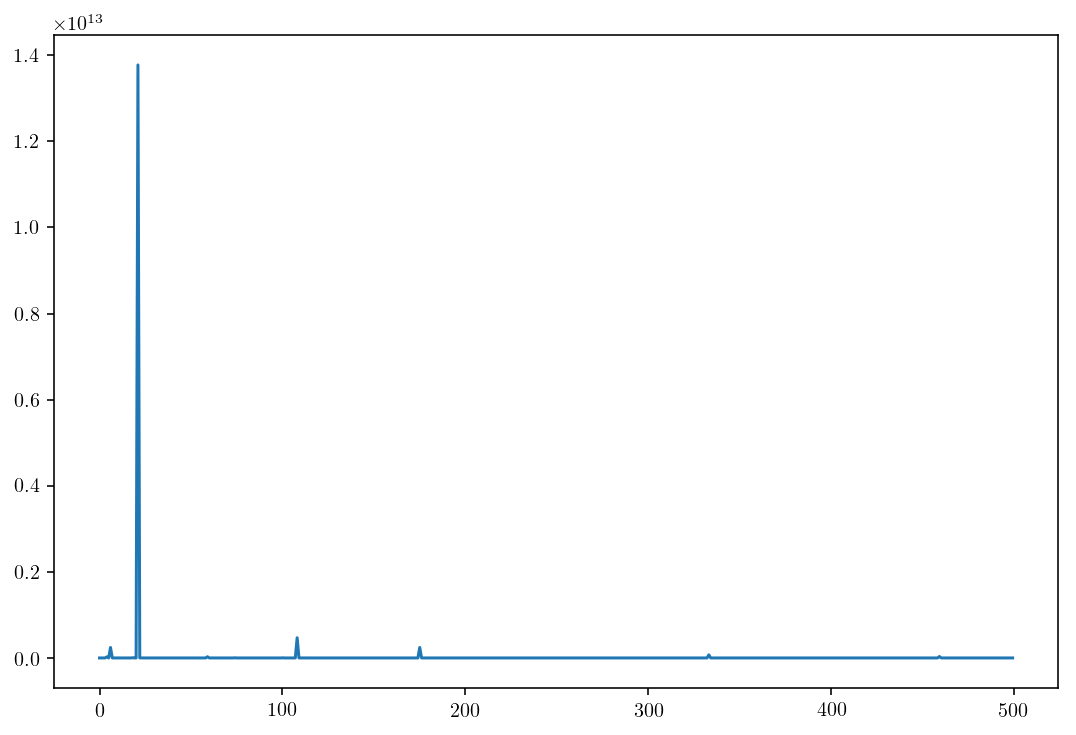

In [268]:
pyro.clear_param_store()
n_steps = 500
losses = []
for s in range(n_steps):
    if (i+1)%50==0:
        print(i+1)
    losses.append(svi.step(train_data))
plt.plot(losses)
plt.show

In [ ]:
#mode of x ~ Gamma(a,b) = (a-1)/b if a>1

In [271]:
learned_means = pyro.param('m_loc').detach().numpy()

learned_a = pyro.param('s_shape').detach()
learned_b = pyro.param('s_rate').detach()
scale = dist.Gamma(learned_a,learned_b).mean

In [272]:
print(scale)
print(learned_scales)

tensor([[36.4349, 72.0892, 65.7824],
        [98.9427, 70.6059, 55.8593],
        [ 2.9558, 15.9364, 48.2106],
        [48.8759, 67.9831, 58.6410],
        [37.0939, 45.9316,  1.3470]])
tensor([[21.6787, 68.9999, 54.7521],
        [76.9212, 66.1988, 54.1374],
        [-3.5203,  5.2120, 42.0210],
        [42.6494, 65.6621, 55.8118],
        [35.5123, 41.5739, -2.5958]])


In [273]:
print("learned_means")
print(learned_means)
print("true means")
print(true_means.numpy())
print("true_scales")
print(covs.numpy())
print("learned_scales")
print(scale.numpy())

learned_means
[[  3.227243    5.4423146  -1.5541857]
 [-15.866419    4.697155   -1.9664856]
 [ -1.055626   15.459549   -2.236875 ]
 [  3.2325637   5.158386   -1.8900738]
 [  4.9610868   4.853935    6.294296 ]]
true means
[[  2.9758024   -4.5395665  -10.250894  ]
 [-15.087605   -21.359213     0.59340906]
 [ 10.344729    18.211649     4.0894766 ]
 [-13.505105     8.19605    -18.104912  ]
 [ 15.726515     3.6664042   -2.5514522 ]]
true_scales
[[[17.707064    9.27794    10.970502  ]
  [ 9.27794     6.1643257   5.730085  ]
  [10.970502    5.730085   14.0241585 ]]

 [[28.586258   19.263525    3.7065368 ]
  [19.263525   21.599226    1.7725867 ]
  [ 3.7065368   1.7725867   0.9031234 ]]

 [[ 7.8167706  -0.8788681  -4.4367385 ]
  [-0.8788681   0.38130295 -0.06227172]
  [-4.4367385  -0.06227172  4.4941564 ]]

 [[ 9.658234   -7.7146435  -2.9650712 ]
  [-7.7146435  13.376249   -2.334474  ]
  [-2.9650712  -2.334474    7.5372915 ]]

 [[14.488796    4.284322    5.1205616 ]
  [ 4.284322   24.870705   1

In [72]:
'''
Ian's GMM code for comparison
I am trying to switch the generating distribution for the scales to be something with positive support (Gamma)

'''

C = 5
D = 3
def model(data_len,p=False):
    with pyro.plate('class'):
        mu = pyro.sample('mu',dist.MultivariateNormal(torch.zeros([C,D]),torch.diag_embed(torch.ones([C,D])*50)))
        scales = pyro.sample('scales',dist.MultivariateNormal(torch.ones([C,D])*4.05,torch.diag(torch.ones(D)/1.)))
    weights = torch.ones([data_len,C])/C # prior of equal class probabilities
    with pyro.plate('data',data_len) as ind:
        assignment = pyro.sample('assignment',dist.Categorical(weights[ind]))
        obs = pyro.sample('obs',dist.MultivariateNormal(mu[assignment],torch.diag_embed(scales[assignment])))
    return obs, assignment

def guide(data_len,p=False):
    mu_loc   = pyro.param('mu_loc', torch.zeros([C,D]))
    mu_tril= pyro.param("mu_tril", torch.diag_embed(torch.randn([C,D]).abs()), constraint = constraints.lower_cholesky)


     #scales variational params
    scales_loc = pyro.param("scales_loc",torch.ones([C,D])*10)
    scales_tril= pyro.param("scales_tril", torch.diag_embed(torch.randn([C,D]).abs()), constraint = constraints.lower_cholesky)


    with pyro.plate('class'):
        mu = pyro.sample('mu',dist.MultivariateNormal(mu_loc,scale_tril=mu_tril))
        scales = pyro.sample('scales',dist.MultivariateNormal(scales_loc,scale_tril=scales_tril))
    if p:
        print(mu)
    w = pyro.param('weights',torch.ones([data_len,C])/C,constraint=constraints.simplex)
#     print(w)
    with pyro.plate('data',data_len) as ind:
#         print(ind)
        assignment = pyro.sample('assignment',dist.Categorical(w[ind]),infer={"enumerate": "parallel"})

In [67]:
pyro.clear_param_store()
model

In [78]:
torch.stack(N_classes*(torch.eye(dims),)).shape

torch.Size([5, 3, 3])

In [236]:
g = dist.Gamma(5*torch.ones((N_classes,dims)),2*torch.ones((N_classes,dims)),validate_args=True)
print(g.event_shape,g.batch_shape)
g = g.to_event(1)
print(g.event_shape,g.batch_shape)

torch.Size([]) torch.Size([5, 3])
torch.Size([3]) torch.Size([5])


In [220]:
m_loc = pyro.param('m_loc',10*torch.randn((N_classes,dims)))
m_scale = pyro.param('m_scale',5*torch.stack(N_classes*(torch.eye(dims),)) ,constraint=constraints.lower_cholesky)
s_shape = pyro.param('s_shape',10*torch.rand(N_classes,dims), constraint=constraints.positive)
s_rate = pyro.param('s_rate', 0.5*torch.ones((N_classes,dims)) ,constraint=constraints.positive)
    
with pyro.plate('classes'):
        means = pyro.sample('means',dist.MultivariateNormal(m_loc,scale_tril=m_scale))
        scales = pyro.sample('scales',dist.Gamma(s_shape, s_rate))